### Data cleaning
- Cleaning the values of categorical attributes (renaming by dictionary, mark unpopular as the OTHER group...)
- Convert the date feature types and generate different time features
- Convert float features and calculate correct amounts
- Calculate ranks (percentiles) of amounts and property size in the groups (for easy filtering outliers in the data)
- Geographical matching

In [1]:
plt.style.use('bmh')
color = '#1240AB'

In [2]:
t1 = dt.now()
print(t1)

2023-05-20 11:18:19.987196


#### Read

In [3]:
df1 = pd.read_csv('../data/transactions.csv', sep = ';')
print(df1.shape)
df1[:3]

(995975, 23)


,Transaction Number,Transaction Date,Property ID,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,Transaction Size (sq.m),Property Size (sq.m),Room(s),Parking,Nearest Metro,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,Master Project,Project
0,13-7700-2022,02/06/2022 16:18,44581083,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,AKOYA OXYGEN,Land,Residential,"570,400.00",174.80,174.80,NaN,NaN,NaN,NaN,Dubai Cycling Course,0.00,0.00,NaN,DAMAC HILLS (2) - ODORA
1,13-7699-2022,02/06/2022 16:14,44014284,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,AKOYA OXYGEN,Land,Residential,"530,000.00",174.80,174.80,NaN,NaN,NaN,NaN,Dubai Cycling Course,0.00,0.00,NaN,DAMAC HILLS (2) - ZINNIA
2,14-563-2022,02/06/2022 15:42,280311,Mortgage,Modify Mortgage,Ready,Non Free Hold,Residential,Al Barshaa South First,Land,Residential,"500,000.00","1,188.42","1,188.42",NaN,NaN,Sharaf Dg Metro Station,Mall of the Emirates,Motor City,0.00,0.00,NaN,NaN


In [4]:
n = df1.shape[0]
s = pd.concat([(df1.isnull().sum()).reset_index().T, df1.nunique().reset_index().T[1:], df1.dtypes.reset_index().T[1:]])
s.index = ['feat','nulls','unique','type']
s

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
feat,Transaction Number,Transaction Date,Property ID,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,Transaction Size (sq.m),Property Size (sq.m),Room(s),Parking,Nearest Metro,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,Master Project,Project
nulls,0,0,0,0,0,0,0,0,0,0,22252,0,125727,3,237817,493342,216136,220061,103369,188,188,995686,407287
unique,911106,546434,507504,3,49,2,2,2,372,3,47,233885,75360,72833,16,77904,58,7,16,29,56,4,1608
type,object,object,int64,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,object,object,object,float64,float64,object,object


In [5]:
df1['Property ID'].value_counts()[:10]

53492061    52
53491842    45
53491755    45
837486      40
312957      26
312816      26
313278      24
312822      23
312819      22
313326      22
Name: Property ID, dtype: int64

In [6]:
# list(df1.columns)

In [7]:
[
 # 'Transaction Number',
 # 'Transaction Date',
 # 'Property ID',
 # 'Transaction Type',
 # 'Transaction sub type',
 'Registration type',
 # 'Is Free Hold?',
 # 'Usage',
 'Area',
 # 'Property Type',
 # 'Property Sub Type',
 'Amount',
 'Transaction Size (sq.m)',
 'Property Size (sq.m)',
 # 'Room(s)',
 # 'Parking',
 # 'Nearest Metro',
 # 'Nearest Mall',
 # 'Nearest Landmark',
 'No. of Buyer',
 'No. of Seller',
 # 'Master Project',
 # 'Project'
]

['Registration type',
 'Area',
 'Amount',
 'Transaction Size (sq.m)',
 'Property Size (sq.m)',
 'No. of Buyer',
 'No. of Seller']

#### Transaction types exploring

In [8]:
df1['Transaction Type'].value_counts()

Sales       706096
Mortgage    258936
Gifts        30943
Name: Transaction Type, dtype: int64

In [9]:
df1['Transaction sub type'].value_counts()

Sale                                                320565
Sell - Pre registration                             252047
Mortgage Registration                               129946
Delayed Sell                                         77843
Lease to Own Registration                            53081
Grant                                                28995
Portfolio Mortgage Registration                      26984
Portfolio Mortgage Modification                      21459
Modify Mortgage                                      16115
Development Registration                             11014
Lease to Own Registration Pre-Registration            8375
Delayed Mortgage                                      7789
Sell Development                                      6979
Lease Finance Registration                            5817
Mortgage Pre-Registration                             5621
Development Mortgage                                  3825
Mortgage Transfer                                     30

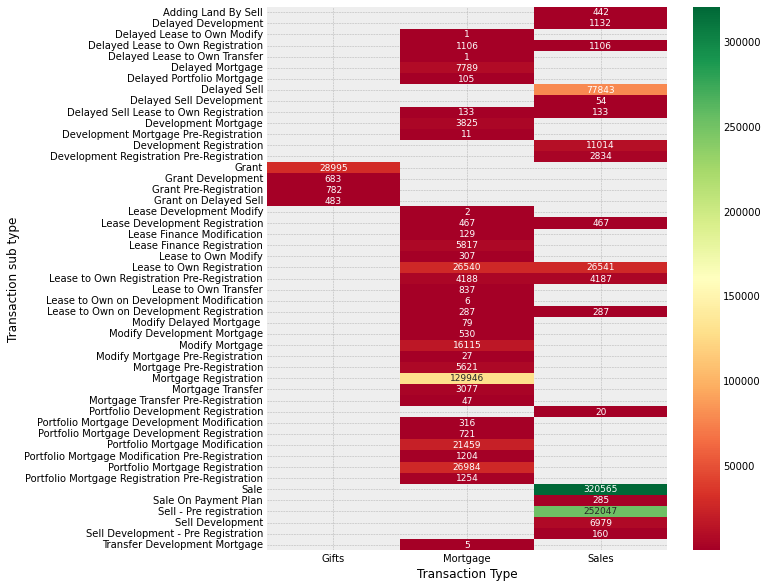

In [10]:
df2 = df1.fillna('').groupby(['Transaction Type', 'Transaction sub type']).size().unstack().T

_, ax = plt.subplots(figsize = (8,10))
_ = sns.heatmap(df2, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.0f', annot_kws={"size": 9})

In [11]:
df1['Registration type'].value_counts()

Ready       723613
Off-Plan    272362
Name: Registration type, dtype: int64

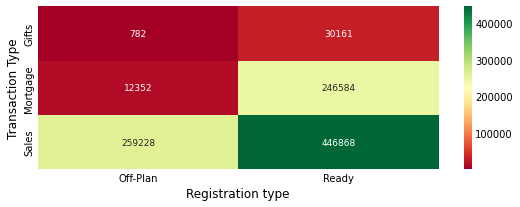

In [12]:
df2 = df1.fillna('').groupby(['Registration type', 'Transaction Type']).size().unstack().T

_, ax = plt.subplots(figsize = (8,3))
_ = sns.heatmap(df2, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.0f', annot_kws={"size": 9})

In [13]:
# Mortgage amounts are very strange - from that data we are not able to understand what's the share of property have been paid
# some examples
i = 89695584
df1[df1['Property ID'] == i]

,Transaction Number,Transaction Date,Property ID,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,Transaction Size (sq.m),Property Size (sq.m),Room(s),Parking,Nearest Metro,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,Master Project,Project
403416,13-6343-2016,29/08/2016 13:57,89695584,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Building,Villa,"1,575,000.00",174.78,174.78,3 B/R,NaN,Dubai Internet City,Mall of the Emirates,Sports City Swimming Academy,0.00,0.00,NaN,SUNSET GARDENS
403430,11-10262-2016,29/08/2016 13:09,89695584,Sales,Sale,Ready,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Building,Villa,"2,100,000.00",174.78,174.78,3 B/R,NaN,Dubai Internet City,Mall of the Emirates,Sports City Swimming Academy,2.00,1.00,NaN,SUNSET GARDENS


In [14]:
# some examples
i = 38813508
df1[df1['Property ID'] == i]

,Transaction Number,Transaction Date,Property ID,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,Transaction Size (sq.m),Property Size (sq.m),Room(s),Parking,Nearest Metro,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,Master Project,Project
175972,13-3425-2020,12/05/2020 10:47,38813508,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,DUBAI SCIENCE PARK,Land,Residential,"2,014,607.00",600.94,600.94,NaN,NaN,Sharaf Dg Metro Station,Mall of the Emirates,Motor City,0.00,0.00,NaN,Villa Lantana 1
340900,13-6565-2017,02/08/2017 09:05,38813508,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,DUBAI SCIENCE PARK,Land,Residential,"2,212,500.00",600.94,600.94,NaN,NaN,Sharaf Dg Metro Station,Mall of the Emirates,Motor City,0.00,0.00,NaN,Villa Lantana 1
457420,190-215-2015,12/10/2015 12:07,38813508,Mortgage,Delayed Mortgage,Ready,Free Hold,Residential,DUBAI SCIENCE PARK,Land,Residential,"2,212,500.00",600.94,600.94,NaN,NaN,Sharaf Dg Metro Station,Mall of the Emirates,Motor City,0.00,0.00,NaN,Villa Lantana 1
503057,41-528-2015,22/01/2015 10:47,38813508,Sales,Delayed Sell,Ready,Free Hold,Residential,DUBAI SCIENCE PARK,Land,Residential,"4,425,000.00",600.94,600.94,NaN,NaN,Sharaf Dg Metro Station,Mall of the Emirates,Motor City,1.00,1.00,NaN,Villa Lantana 1


In [15]:
# some examples
i = 834087417
df1[df1['Property ID'] == i]

,Transaction Number,Transaction Date,Property ID,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,Transaction Size (sq.m),Property Size (sq.m),Room(s),Parking,Nearest Metro,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,Master Project,Project
71055,13-12706-2021,07/10/2021 10:43,834087417,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,MUDON,Land,Residential,"2,374,400.00",293.80,293.80,NaN,NaN,NaN,NaN,Dubai Cycling Course,0.00,0.00,NaN,MUDON PHASE 3 _ NEIGHBOURHOOD I- ARABELLA
71056,11-17806-2021,07/10/2021 10:43,834087417,Sales,Sale,Ready,Free Hold,Residential,MUDON,Land,Residential,"2,800,000.00",293.80,293.80,NaN,NaN,NaN,NaN,Dubai Cycling Course,2.00,1.00,NaN,MUDON PHASE 3 _ NEIGHBOURHOOD I- ARABELLA
464202,41-5380-2015,31/08/2015 14:35,834087417,Sales,Delayed Sell,Ready,Free Hold,Residential,Al Hebiah Third,Land,Residential,"2,279,000.00",293.80,293.80,NaN,NaN,NaN,NaN,NaN,1.00,1.00,NaN,NaN


In [16]:
# we will took only Sale transactions
f1 = df1['Transaction Type'] == 'Sales'
f2 = ~df1['Property Size (sq.m)'].isnull()
print(df1.shape)
df1 = df1[f1&f2]
print(df1.shape)

(995975, 23)
(706096, 23)


#### Categorical features

In [17]:
# Rooms
repl1 = {
 '5 B/R': '5 B/R and more',
 '6 B/R': '5 B/R and more',
 '7 B/R': '5 B/R and more',
 '8 B/R': '5 B/R and more',
}
feat = 'Room(s)'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

# unpopoular as other
repl1 = df1[feat+ ' CLEAN'].value_counts()
repl1 = repl1[repl1 > 99]
df1[feat+ ' CLEAN'] = df1[feat+ ' CLEAN'].map(lambda x: x if x in repl1.index or x == '' else 'Other')

df1[feat+ ' CLEAN'].value_counts()

1 B/R             190298
                  129732
2 B/R             125389
Studio            111665
3 B/R              70314
Office             44732
4 B/R              20311
Shop                8878
5 B/R and more      2627
PENTHOUSE           1165
Single Room          663
Store Room           305
Other                 17
Name: Room(s) CLEAN, dtype: int64

In [18]:
# Property Type
repl1 = {
}
feat = 'Property Type'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)
df1[feat+ ' CLEAN'].value_counts()

Unit        527561
Land        125074
Building     53461
Name: Property Type CLEAN, dtype: int64

In [19]:
# Property Sub Type
repl1 = {
    'Hotel Apartment': 'Hotel',
    'Hotel Rooms': 'Hotel',
    'Residential Flats': 'Flat',
    'Exhbition Center': 'Show Rooms',
    'Shopping Mall': 'School',
    'Residential / Residential Villa': 'Villa',
    'Residential / Attached Villas': 'Villa',
    'Stacked Townhouses': 'Villa',
    'Hospital': 'Medical center',
    'Clinic': 'Medical center',
}
feat = 'Property Sub Type'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

# unpopoular as other
repl1 = df1[feat+ ' CLEAN'].value_counts()
repl1 = repl1[repl1 > 99]
df1[feat+ ' CLEAN'] = df1[feat+ ' CLEAN'].map(lambda x: x if x in repl1.index or x == '' else 'Other')

df1[feat+ ' CLEAN'].value_counts()

Flat                  445496
Residential            65307
Villa                  55361
Office                 46441
Commercial             40052
Hotel                  27343
Shop                    9279
                        8466
Industrial              1695
Land                    1291
General Use              945
Labor Camp               669
Airport                  614
Agricultural             577
Unit                     502
Workshop                 415
Government Housing       378
Sports Club              365
Store                    305
Other                    242
Warehouse                225
Building                 128
Name: Property Sub Type CLEAN, dtype: int64

In [20]:
# Usage
repl1 = {
}
feat = 'Usage'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

df1[feat+ ' CLEAN'].value_counts()

Residential    663246
Commercial      42850
Name: Usage CLEAN, dtype: int64

In [21]:
# Nearest Landmark
repl1 = {
}
feat = 'Nearest Landmark'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

# unpopoular as other
repl1 = df1[feat+ ' CLEAN'].value_counts()
repl1 = repl1[repl1 > 99]
df1[feat+ ' CLEAN'] = df1[feat+ ' CLEAN'].map(lambda x: x if x in repl1.index or x == '' else 'Other')

df1[feat+ ' CLEAN'].value_counts()

Sports City Swimming Academy         165096
Burj Al Arab                         137073
Downtown Dubai                        90331
                                      79216
Motor City                            46588
IMG World Adventures                  45291
Dubai International Airport           40137
Burj Khalifa                          34213
Dubai Cycling Course                  24987
Expo 2020 Site                        23734
Global Village                         6896
Dubai Parks and Resorts                4043
Al Makhtoum International Airport      3960
Hamdan Sports Complex                  3249
Jabel Ali                              1280
Other                                     2
Name: Nearest Landmark CLEAN, dtype: int64

In [22]:
# Nearest Mall
repl1 = {
}
feat = 'Nearest Mall'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

# unpopoular as other
repl1 = df1[feat+ ' CLEAN'].value_counts()
repl1 = repl1[repl1 > 99]
df1[feat+ ' CLEAN'] = df1[feat+ ' CLEAN'].map(lambda x: x if x in repl1.index or x == '' else 'Other')


df1[feat+ ' CLEAN'].value_counts()

Marina Mall             246196
                        157962
Dubai Mall              133309
City Centre Mirdif       69518
Mall of the Emirates     61594
Ibn-e-Battuta Mall       37515
Other                        2
Name: Nearest Mall CLEAN, dtype: int64

In [23]:
# Nearest Metro
repl1 = {
    'Jumeirah Beach Resdency': 'Jumeirah Beach Residency'
}
feat = 'Nearest Metro'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

# unpopoular as other
repl1 = df1[feat+ ' CLEAN'].value_counts()
repl1 = repl1[repl1 > 99]
df1[feat+ ' CLEAN'] = df1[feat+ ' CLEAN'].map(lambda x: x if x in repl1.index or x == '' else 'Other')

df1[feat+ ' CLEAN'].value_counts()

                                        154215
Buj Khalifa Dubai Mall Metro Station     59573
Rashidiya Metro Station                  53268
Nakheel Metro Station                    51355
Business Bay Metro Station               51005
Dubai Internet City                      45334
Damac Properties                         41698
Jumeirah Lakes Towers                    37737
Jumeirah Beach Residency                 34139
Harbour Tower                            18481
Sharaf Dg Metro Station                  16354
Mina Seyahi                              16339
Palm Jumeirah                            15873
First Abu Dhabi Bank Metro Station       15506
Ibn Battuta Metro Station                10839
Creek Metro Station                      10451
Marina Towers                             9616
Marina Mall Metro Station                 8487
DANUBE Metro Station                      7269
Noor Bank Metro Station                   6677
Dubai Marina                              6478
Trade Centre 

In [24]:
# Project
repl1 = {
}
feat = 'Project'
df1[feat+ ' CLEAN'] = df1[feat].fillna('').str.strip().map(lambda x: repl1[x] if x in repl1 else x)

# unpopoular as other
repl1 = df1[feat+ ' CLEAN'].value_counts()
repl1 = repl1[repl1 > 99]
df1[feat+ ' CLEAN'] = df1[feat+ ' CLEAN'].map(lambda x: x if x in repl1.index or x == '' else 'Other')

df1[feat+ ' CLEAN'].value_counts().sort_index()

                               240177
15 Northside                      351
17 ICON BAY                       380
2020 Marquis                      117
23 MARINA                         793
                                ...  
XL TOWER                          389
ZADA TOWER                        660
ZENITH TOWER A1                   287
ZUMURUD DUBAI MARINA              283
joya verde residences dubai       117
Name: Project CLEAN, Length: 1045, dtype: int64

#### Dates

In [25]:
# dates features
feats1 = ['Transaction Date']
for f in feats1:
    df1[f] = pd.to_datetime(df1[f], errors = 'coerce', dayfirst = True)  
df1['tr_day']     = pd.to_datetime(df1['Transaction Date'].astype(str).str[:10])
df1['tr_month']   = pd.to_datetime(df1['Transaction Date'].astype(str).str[:7])
df1['tr_quarter'] = df1['Transaction Date'].astype(str).str[:4] + 'Q' + pd.to_datetime(df1['Transaction Date']).dt.quarter.astype(str)
df1['tr_year']    = df1['Transaction Date'].astype(str).str[:4]

In [26]:
df1[:5]

,Transaction Number,Transaction Date,Property ID,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,Transaction Size (sq.m),Property Size (sq.m),Room(s),Parking,Nearest Metro,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,Master Project,Project,Room(s) CLEAN,Property Type CLEAN,Property Sub Type CLEAN,Usage CLEAN,Nearest Landmark CLEAN,Nearest Mall CLEAN,Nearest Metro CLEAN,Project CLEAN,tr_day,tr_month,tr_quarter,tr_year
3,11-12317-2022,2022-06-02 15:22:00,79102731,Sales,Sale,Ready,Free Hold,Commercial,AL FURJAN,Land,Commercial,"1,500,000.00",600.51,600.51,NaN,NaN,NaN,NaN,NaN,1.00,1.00,NaN,NaN,,Land,Commercial,Commercial,,,,,2022-06-02,2022-06-01,2022Q2,2022
4,11-12316-2022,2022-06-02 15:07:00,132952797,Sales,Sale,Ready,Free Hold,Residential,AKOYA OXYGEN,Land,Residential,"815,000.00",112.24,112.24,NaN,NaN,NaN,NaN,Dubai Cycling Course,1.00,1.00,NaN,DAMAC HILLS (2) - AMARGO,,Land,Residential,Residential,Dubai Cycling Course,,,DAMAC HILLS (2) - AMARGO,2022-06-02,2022-06-01,2022Q2,2022
5,102-14693-2022,2022-06-02 14:56:00,1134745314,Sales,Sell - Pre registration,Off-Plan,Free Hold,Residential,AL FURJAN,Unit,Flat,"425,993.00",49.47,49.47,Studio,1.00,Ibn Battuta Metro Station,Ibn-e-Battuta Mall,Expo 2020 Site,0.00,1.00,NaN,Prime Residency 3,Studio,Unit,Flat,Residential,Expo 2020 Site,Ibn-e-Battuta Mall,Ibn Battuta Metro Station,Prime Residency 3,2022-06-02,2022-06-01,2022Q2,2022
6,102-14692-2022,2022-06-02 14:54:00,750930096,Sales,Sell - Pre registration,Off-Plan,Free Hold,Residential,ARABIAN RANCHES III,Building,Villa,"1,550,000.00",128.58,128.58,3 B/R,NaN,NaN,NaN,Hamdan Sports Complex,2.00,1.00,NaN,Arabian Ranches III - JOY,3 B/R,Building,Villa,Residential,Hamdan Sports Complex,,,Arabian Ranches III - JOY,2022-06-02,2022-06-01,2022Q2,2022
8,11-12315-2022,2022-06-02 14:52:00,41160822,Sales,Sale,Ready,Free Hold,Residential,PALM JUMEIRAH,Unit,Flat,"1,900,000.00",167.94,167.94,2 B/R,NaN,Palm Jumeirah,Marina Mall,Burj Al Arab,1.00,1.00,NaN,GOLDEN MILE,2 B/R,Unit,Flat,Residential,Burj Al Arab,Marina Mall,Palm Jumeirah,GOLDEN MILE,2022-06-02,2022-06-01,2022Q2,2022


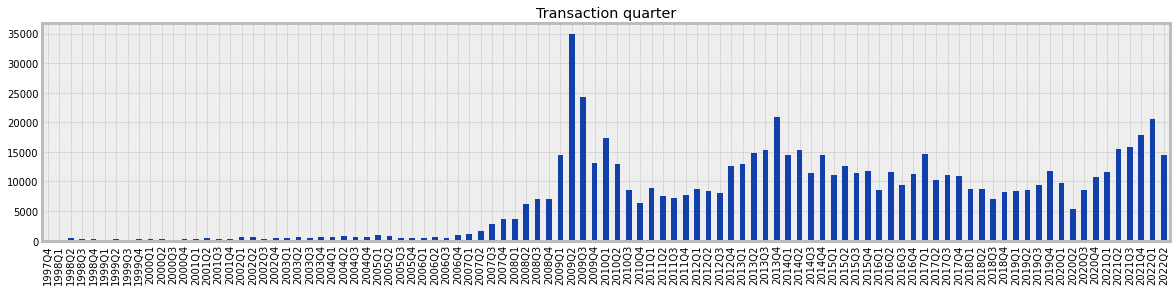

In [27]:
# plot
color = '#1240AB'

_, ax = plt.subplots(1,1, figsize = (18,4))
_ = df1.tr_quarter.value_counts().sort_index().plot(ax = ax, kind = 'bar', color = color, title = 'Transaction quarter')

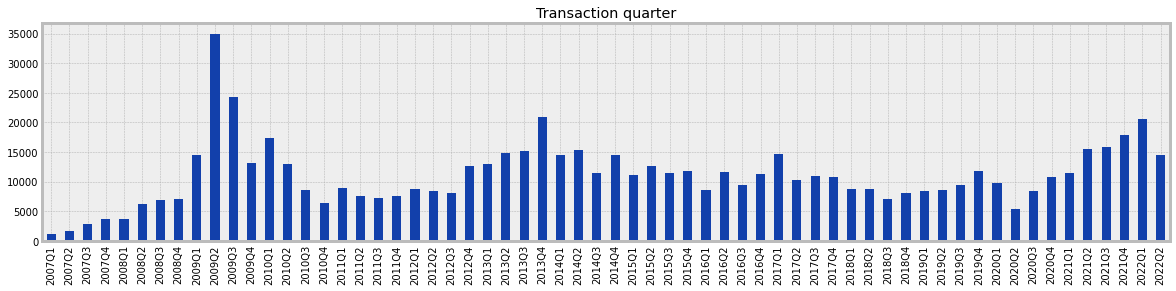

In [28]:
# plot
color = '#1240AB'

_, ax = plt.subplots(1,1, figsize = (18,4))
_ = df1.tr_quarter.value_counts().sort_index()['2007Q1':].plot(ax = ax, kind = 'bar', color = color, title = 'Transaction quarter')

In [29]:
# let's took the data from 2012
f1 = df1.tr_quarter >= '2012Q1'
print(df1.shape)
df1 = df1[f1]
print(df1.shape)

(706096, 35)
(493020, 35)


In [30]:
n = df1.shape[0]
s = pd.concat([(df1.isnull().sum()).reset_index().T, df1.nunique().reset_index().T[1:], df1.dtypes.reset_index().T[1:]])
s.index = ['feat','nulls','unique','type']
s

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
feat,Transaction Number,Transaction Date,Property ID,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,Transaction Size (sq.m),Property Size (sq.m),Room(s),Parking,Nearest Metro,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,Master Project,Project,Room(s) CLEAN,Property Type CLEAN,Property Sub Type CLEAN,Usage CLEAN,Nearest Landmark CLEAN,Nearest Mall CLEAN,Nearest Metro CLEAN,Project CLEAN,tr_day,tr_month,tr_quarter,tr_year
nulls,0,0,0,0,0,0,0,0,0,0,7174,0,36621,0,86905,211578,122678,123888,49637,131,131,492766,126532,0,0,0,0,0,0,0,0,0,0,0,0
unique,492280,361302,372864,1,18,2,2,2,305,3,43,132241,56878,56468,16,60281,57,6,15,20,45,3,1411,13,3,22,2,16,7,51,983,2951,126,42,11
type,object,datetime64[ns],int64,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,object,object,object,float64,float64,object,object,object,object,object,object,object,object,object,object,datetime64[ns],datetime64[ns],object,object


#### Float features

In [31]:
feat = 'Property Size (sq.m)'
df1.loc[df1[feat] < 1, feat] = np.nan

feat = 'Transaction Size (sq.m)'
df1.loc[df1[feat] < 1, feat] = np.nan

df1['k'] = (df1['Transaction Size (sq.m)'] / df1['Property Size (sq.m)']).fillna(0)
df1['k'] = df1.k.map(lambda x: round(x,1))

df1['Price per sq.m'] = df1['Amount'] / df1['Property Size (sq.m)']

In [32]:
list_k = [0,0.5,0.9,1,1.1,2]

x = df1.k.value_counts(normalize = True).sort_index()
x[list_k]

0.00   0.07
0.50   0.01
0.90   0.00
1.00   0.90
1.10   0.01
2.00   0.00
Name: k, dtype: float64

In [33]:
df1[df1.k.isin(list_k)].groupby(['Property Type', 'k'])['Price per sq.m'].agg([np.mean, np.median, len]).unstack()

mean                                                   \
k                  0.00     0.50      0.90      1.00      1.10      2.00   
Property Type                                                              
Building       7,570.14 4,128.83  8,102.72  8,791.58  9,322.07  6,823.11   
Land           1,281.58 4,402.71 11,845.11  7,787.05  7,741.82  3,227.56   
Unit          16,352.72 6,934.35 17,494.86 13,747.14 15,569.01 20,513.64   

                 median                                                   \
k                  0.00     0.50      0.90      1.00      1.10      2.00   
Property Type                                                              
Building       6,399.50 3,573.31  8,284.02  8,172.26  7,359.64  6,187.10   
Land             361.65 2,763.92 10,757.65  6,947.44  3,599.68    626.10   
Unit          15,062.20 5,381.95 13,091.15 11,631.94 13,424.88 20,134.59   

                 len                                 
k               0.00  0.50  0.90    1.00  1.10 2.00  
Property Type                                        
Building        4458   112    72   38396    18    9  
Land             219   903   456   80137    79  459  
Unit           32219  1763  1755  322859  3002  639

In [34]:
# there is no exact answer what is the transaction squared meters so let's consider only the records with small delta between values
f1 = df1['k'].between(0.99,1.01)
print(df1.shape)
print(df1[f1].shape)

df1 = df1[f1]

(493020, 37)
(441392, 37)


In [35]:
# logarithm features
feats_num = ['Amount','Property Size (sq.m)','Price per sq.m']
for feat in feats_num:
    df1[feat + ' LOG'] = df1[feat].map(np.log)

In [36]:
# Calculate ranks (percentiles) of amounts and property size by the cleaned Property Type (For easy filtering outliers)
feats_gr = ['Property Type CLEAN','tr_year']
for feat in feats_num:
    df1[feat + ' RANK'] = df1.groupby(feats_gr)[feat].transform(lambda x: x.rank(pct = True))

In [37]:
# flags
df1['reg_ready']   = df1['Registration type'].map({'Ready': 1}).fillna(0).astype(int)
df1['free_hold']   = df1['Is Free Hold?'].map({'Free Hold': 1}).fillna(0).astype(int)
df1['Parking'] = df1['Parking'].notnull().astype(int)

# unused
feats_drop = ['Master Project','Is Free Hold?']
for f in feats_drop:
    del df1[f]

#### Geographical matching
- get one table with polygons by regions and sectors, show the borders
- create table with unique regions presented in the data
- create dictionaries to replace the names of the regions like it is in the shape file
- merge with polygons and write to file

(222, 3)
(222, 4)
222


,sector,geometry1,region,geometry2
0,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...",ABU HAIL,"POLYGON ((55.32696 25.27903, 55.32659 25.27963..."
1,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...",AL BARAHA,"POLYGON ((55.32234 25.28839, 55.32465 25.28369..."
2,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...",AL BUTEEN,"POLYGON ((55.30154 25.26731, 55.29993 25.26727..."
3,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...",AL CORNICHE,"POLYGON ((55.29571 25.27332, 55.29556 25.27379..."
4,1,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...",AL DHAGAYA,"POLYGON ((55.30041 25.27093, 55.30000 25.27087..."


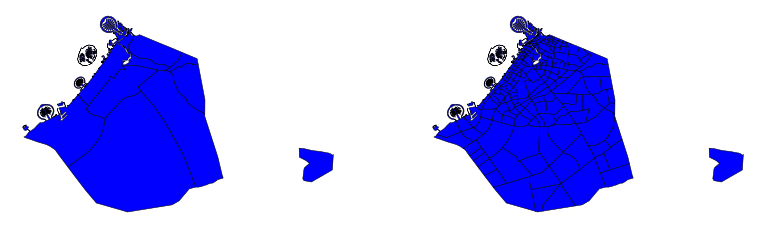

In [38]:
# get one table with polygons by regions and sectors, show the borders
import geopandas as gpd

df_area1 = gpd.read_file('../data/geo/gadm/gadm41_ARE_2.shp')
feats_used = ['NAME_2','geometry']
df_area1 = df_area1[df_area1.NAME_1 == 'Dubai'][feats_used].rename(columns = {'geometry': 'geometry1'})

df_area2 = gpd.read_file('../data/geo/gadm/gadm41_ARE_3.shp')
feats_used = ['NAME_2','NAME_3','geometry']
df_area2 = df_area2[df_area2.NAME_1 == 'Dubai'][feats_used].rename(columns = {'geometry': 'geometry2'})

df_area = df_area1.merge(df_area2).rename(columns = {'NAME_2':'sector','NAME_3': 'region'})
print(df_area2.shape)
print(df_area.shape)
print(df_area.region.nunique())

repl1 = {
    'Jebel Ali Industrial First': 'Jebel Ali Industrial Area First',
    'Jebel Ali Industrial Second': 'Jebel Ali Industrial Area Second',
    'Jebel Ali Industrial Third': 'Jebel Ali Industrial Area Third',
}
df_area['sector'] = df_area['sector'].map(lambda x: int(x.split(' ')[1]))
df_area['region'] = df_area['region'].map(lambda x: x if x not in repl1 else repl1[x])
repl2 = {
    'First': '1',
    'Second': '2',
    'Third': '3',
    'Fourth': '4',
    'Fifth': '5',
    'Sixth': '6',
    'Firs': '1',
    'Seco': '2',
    'Thir': '3',
    'Thrid': '3',
    'One': '1',
    'Two': '2',
    'Three': '3',
    'Four': '4',
    'Five': '5',
    'Six': '6',
}
def fun_repl2(x):
    for k,v in repl2.items():
        x = x.replace(k,v)
    return x.strip()
df_area['region'] = df_area['region'].map(fun_repl2)
df_area['region'] = df_area['region'].str.upper()
display(df_area[:5])

_,ax = plt.subplots(1,2, figsize = (12,6))
_ = gpd.GeoDataFrame(df_area1).rename(columns = {'geometry1':'geometry'}).plot(
    ax = ax[0], edgecolor="black",
)
_ = _.axis('off')

_ = gpd.GeoDataFrame(df_area2).rename(columns = {'geometry2':'geometry'}).plot(
    ax = ax[1], edgecolor="black",
)
_ = _.axis('off')

In [39]:
# df2 = df1.groupby(['Property ID','Area']).size().reset_index().rename(columns = {0:'cnt'})
# print(df2.shape)
# df3 = df2.merge(df2, on = 'Property ID').groupby(['Area_x','Area_y']).size().reset_index().rename(columns = {0:'cnt'})
# print(df3.shape)
# df3

In [40]:
# create table with unique regions presented in the data
df2 = df1.groupby(['Area']).size().reset_index().rename(columns = {0:'cnt'})
df2['cnt_log'] = df2['cnt'].map(np.log)

df2['region'] = df2.Area.str.strip().str.upper()

repl2 = {k.upper(): v.upper() for k,v in repl2.items()}
df2['region'] = df2['region'].map(fun_repl2)

repl3 = {
    'Industrial': 'Industrial Area',
    'Al Aweer': 'Al Awir',
    'Al Barshaa': 'Al Barsha', 
    'Al Eyas': 'Al Ayas',
    "Al Faga'A": "Al Fagaa'",
    'Al Garhoud': 'Al Gharoud',
    'Al Goze': 'Al Quoz',
    'Al Khabeesi': 'Al Khabisi',
    'Al Lusaily': 'El Lesaily',
    'Al Mamzer': 'Al Mamzar',
    'Al Mararr': 'Al Murar',
    'Al Marmoom': 'Al Marmoon',
    'Al Merkadh': 'Al Merkad',
    'Al Nahda': 'Al Nadha',
    'Al Rega': 'Al Rigga',
    'Al Saffa': 'Al Safa',
    'Al Suq Al Kabeer': 'Al Souq Al Kabeer',
    'Al Thanayah': 'Al Tanyah',
    'Al Thanyah': 'Al Tanyah',
    'Al Ttay': 'Al Tay',
    'Al Warqa': "Al Warqa'a",
    'Al Warsan': 'Warsan',
    'Al Yelayiss': 'Al Yalayis',
    'Bukadra': 'Bu Kadra',
    'Cornich Deira': 'Corniche Deira',
    'Dubai International Airport': 'Dubai airport',
    'Hadaeq Sheikh Mohammed Bin Rashid': 'Hadaeq Sheikh Mohammed Bin Rashi',
    'Jabal Ali': 'Jebel Ali',
    'Jumeirah': 'Jumeira',
    'Madinat Dubai Almelaheyah': 'Madinat Dubai Al Melaheyah',
    "Me'Aisem": "Me'aisem",
    'Nad Al Shiba': 'Nad Al Shibba',
    'Oud Al Muteena': 'Oud Al Muteen',
    'Palm Deira': 'Palm Deira (Under Construction)',
    'Rega Al Buteen': 'Rigga Al Buteen',
    'Um Al Sheif': 'Umm Al Sheif',
    'Um Hurair': 'Umm Hurair',
    'Um Nahad': 'Umm Nahad',
    'Um Ramool': 'Umm Ramool',
    'Um Suqaim': 'Umm Suqaim',
    'Wadi Al Amardi': 'Wadi Alamradi',
    'Zaabeel': "Za'abeel",
    'Al Safouh':'Al Sufouh',
    'Al-Cornich': 'Al Corniche',
    'Oud Almuteena': 'Oud Al Muteen',
}
repl3 = {k.upper(): v.upper() for k,v in repl3.items()}
def fun_repl3(x):
    for k,v in repl3.items():
        x = x.replace(k,v)
    return x.strip()
df2['region'] = df2['region'].map(fun_repl3)

repl4 = {
    'Nad Al Shibba': 'Nad Al Shibba 1',
    'Al Hebiah 6': 'Al Hebiah 5',
    'Al Qoaz': 'Al Qoaz 1',
    'Al Qusais': 'Al Qusais 1',
    'Al Ruwayyah': 'Al Rowaiyah 1',
    'Al Yufrah 3':'Al Yufrah 2',
    'Eyal Nasser':'Ayal Nasir',
    'Island 2':'Jumeira Island 2 (Daria Island',
    'Jebel Ali':'Jebel Ali 1',
    'Lehbab':'Lehbab 1',
    'Mankhool':'Al Mankhool',
    'Mirdif':"Al Warqa'a 1",
    'Muragab':'Margab',
    'Palm Jumeira':'Jumeira Island 1',
    'Shandagha':'Al Shandaga',
    'Business Bay': 'Jumeira 1',
}
repl4 = {k.upper(): v.upper() for k,v in repl4.items()}
df2['region'] = df2['region'].map(lambda x: x if x not in repl4 else repl4[x])
df2 = df2.sort_values('region')
print(df2.shape)
print(df2.region.nunique())
df2[:3]

(298, 4)
285


,Area,cnt,cnt_log,region
12,Abu Hail,223,5.41,ABU HAIL
0,AKOYA OXYGEN,9857,9.20,AKOYA OXYGEN
13,Al Aweer First,19,2.94,AL AWIR 1


In [41]:
# new replaces
repl5 = {
 'DUBAI MARINA': 'AL TANYAH 4',
 'JUMEIRAH LAKES TOWERS': 'AL TANYAH 5',
 'JUMEIRAH VILLAGE CIRCLE': 'AL TANYAH 5',
 'INTERNATIONAL CITY PH 1': 'WARSAN 1',
 'DUBAI SPORTS CITY': 'WARSAN 1',
 'SILICON OASIS': 'AL BARSHA SOUTH 4',
 'DUBAI HILLS': 'AL BARSHA SOUTH 1',
 'AKOYA OXYGEN': 'AL HEBIAH 3',
 'AL FURJAN': 'JEBEL ALI 1',
 'DUBAI CREEK HARBOUR': 'RAS AL KHOR ',
 'TOWN SQUARE': 'AL BARSHA SOUTH 1',
 'JUMEIRAH BEACH RESIDENCE': 'AL TANYAH 4',
 'THE GREENS': 'AL TANYAH 3',
 'ARJAN': 'AL BARSHA SOUTH 4',
 'DAMAC HILLS': 'AL HEBIAH 3',
 'DUBAI PRODUCTION CITY': 'AL TANYAH 3',
 'JUMEIRAH VILLAGE TRIANGLE': 'AL BARSHA SOUTH 5',
 'REMRAAM': 'AL HEBIAH 5',
 'JUMEIRAH PARK': 'AL TANYAH 4',
 'DISCOVERY GARDENS': 'JEBEL ALI 1',
 'MOTOR CITY': 'AL HEBIAH 5',
 'SOBHA HEARTLAND': 'AL MERKAD',
 'LIWAN': 'WADI AL SAFA 2',
 'ARABIAN RANCHES I': 'WADI AL SAFA 7',
 'DUBAI HARBOUR': 'AL SUFOUH 1',
 'VILLANOVA': 'WADI AL SAFA 5',
 'DUBAI SOUTH': 'JEBEL ALI 1',
 'BARSHA HEIGHTS': 'AL BARSHA SOUTH 1',
 'JABEL ALI HILLS': 'JEBEL ALI 1',
 'ARABIAN RANCHES II': 'WADI AL SAFA 7',
 'CITY WALK': 'AL WASL',
 'JUMEIRAH GOLF': 'JEBEL ALI 1',
 'THE VILLA': 'WADI AL SAFA 5',
 'ARABIAN RANCHES III': 'WADI AL SAFA 7',
 'AL KHAIL HEIGHTS': 'AL QUOZ 1',
 'MIRA': 'AL BARSHA SOUTH 4',
 'SERENA': 'AL BARSHA SOUTH 4',
 'LA MER': 'JUMEIRA 1',
 'DUBAI HEALTHCARE CITY - PHASE 2': 'OUD METHA',
 'DUBAI SCIENCE PARK': 'AL BARSHA SOUTH 1',
 'INTERNATIONAL CITY PH 2 & 3': 'WARSAN 1',
 'LIVING LEGENDS': 'WADI AL SAFA 3',
 'DOWN TOWN JABAL ALI': 'JEBEL ALI 1',
 'JADDAF WATERFRONT': 'AL JADAF',
 'MUDON': 'AL HEBIAH 6',
 'JUMEIRAH LIVING': 'JUMEIRA 1',
 'BLUEWATERS': 'JUMEIRA 1',
 'DUBAI INDUSTRIAL CITY': 'JEBEL ALI 1',
 'AL BARARI': 'NAD AL SHIBBA 1',
 'NAD AL SHEBA GARDENS': 'NAD AL SHIBBA 1',
 'JUMEIRAH ISLANDS': 'JEBEL ALI 1',
 'THE WORLD': 'WORLD ISLANDS',
 'GRAND VIEWS': 'NAD AL SHIBBA 1',
 'PEARL JUMEIRA': 'JUMEIRA 1',
 'JUMEIRAH HEIGHTS': 'JUMEIRA 1',
 'SUSTAINABLE CITY': 'WADI AL SAFA 7',
 'JUMEIRA BAY': 'JUMEIRA 1',
 'SUFOUH GARDENS': 'AL SUFOUH 1',
 'DUBAI WATER FRONT': 'JEBEL ALI 1',
 'DUBAI HEALTHCARE CITY - PHASE 1': 'OUD METHA',
 'LIWAN 2': 'WADI AL SAFA 2',
 'SAMA AL JADAF': 'AL JADAF',
 'ARABIAN RANCHES POLO CLUB': 'WADI AL SAFA 7',
 'MEDYAN RACE COURSE VILLAS': 'NAD AL SHIBBA 1',
 'MINA RASHID': 'AL HAMRIYA',
 'JABAL ALI VILLAGE': 'JEBEL ALI 1',
 'JABAL ALI STAFF ACCOMMODATION': 'JEBEL ALI 1',
 'JUMEIRA LAKES TOWERS': 'JUMEIRA 1',
 'JUMEIRA VILLAGE CIRCLE': 'JUMEIRA 1',
 'JUMEIRA BEACH RESIDENCE': 'JUMEIRA 1',
 'JUMEIRA VILLAGE TRIANGLE': 'JUMEIRA 1',
 'JUMEIRA GOLF': 'JUMEIRA 1',
 'JUMEIRA PARK': 'JUMEIRA 1',
 'JUMEIRA LIVING': 'JUMEIRA 1',
 'JUMEIRAH ISLANDS': 'JUMEIRAH ISLAND 1',
 'DUBAI CREEK HARBOUR': 'AL KHAIRAN 1',
}
df2['region'] = df2['region'].map(lambda x: x if x not in repl5 else repl5[x])

df2 = df2.sort_values('region')
print(df2.shape)
print(df2.region.nunique())
df2[:3]

(298, 4)
226


,Area,cnt,cnt_log,region
12,Abu Hail,223,5.41,ABU HAIL
13,Al Aweer First,19,2.94,AL AWIR 1
14,Al Aweer Second,15,2.71,AL AWIR 2


In [42]:
# merge with polygons
df3 = df2.merge(df_area, how = 'left')
print(df3.cnt.sum(), df3.shape)
df3[:3]

441392 (298, 7)


,Area,cnt,cnt_log,region,sector,geometry1,geometry2
0,Abu Hail,223,5.41,ABU HAIL,1.00,"MULTIPOLYGON (((55.34077 25.24169, 55.34119 25...","POLYGON ((55.32696 25.27903, 55.32659 25.27963..."
1,Al Aweer First,19,2.94,AL AWIR 1,6.00,"MULTIPOLYGON (((55.24958 24.99299, 55.24823 24...","POLYGON ((55.53066 25.18974, 55.53482 25.19299..."
2,Al Aweer Second,15,2.71,AL AWIR 2,7.00,"POLYGON ((55.66167 25.00837, 55.66156 24.99897...","POLYGON ((55.51106 25.16164, 55.51219 25.16243..."


In [43]:
# matched
df4 = df3[~df3.geometry1.isnull()]
df4['sector'] = df4['sector'].astype(int)
print(df4.cnt.sum(), df4.shape)
# df4

405403 (246, 7)


In [44]:
# unmatched
df5 = df3[df3.geometry1.isnull()]
print(df5.cnt.sum(), df5.shape)
df5.sort_values('cnt', ascending = False)

df5.sort_values('cnt', ascending = False).to_clipboard()

35989 (52, 7)


#### Save to files

In [45]:
# merge with main dataset
df1 = df1.merge(df4[['Area','region','sector']], on = 'Area', how = 'left')

In [52]:
# save geo matchings
df4.to_pickle('../data/df_sales_geo.pkl')

In [46]:
# label encoder of categorical feats by their popularity
feats_cat = [
 'region',
 'Project CLEAN',
 'Nearest Metro CLEAN',
 'Nearest Mall CLEAN',
 'Nearest Landmark CLEAN',
 'Property Type CLEAN',
 'Property Sub Type CLEAN',
 'Usage CLEAN',
 'Room(s) CLEAN'
] 
for f in feats_cat:
    repl = df1[f].fillna('').value_counts()
    repl.iloc[:] = range(len(repl))
    repl = repl.to_dict()
    df1[f + ' LABEL'] = df1[f].fillna('').map(repl)

In [47]:
# save to file
df1.to_pickle('../data/df_sales.pkl')
print(df1.shape)
df1[:3]

(441392, 54)


,Transaction Number,Transaction Date,Property ID,Transaction Type,Transaction sub type,Registration type,Usage,Area,Property Type,Property Sub Type,Amount,Transaction Size (sq.m),Property Size (sq.m),Room(s),Parking,Nearest Metro,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,Project,Room(s) CLEAN,Property Type CLEAN,Property Sub Type CLEAN,Usage CLEAN,Nearest Landmark CLEAN,Nearest Mall CLEAN,Nearest Metro CLEAN,Project CLEAN,tr_day,tr_month,tr_quarter,tr_year,k,Price per sq.m,Amount LOG,Property Size (sq.m) LOG,Price per sq.m LOG,Amount RANK,Property Size (sq.m) RANK,Price per sq.m RANK,reg_ready,free_hold,region,sector,region LABEL,Project CLEAN LABEL,Nearest Metro CLEAN LABEL,Nearest Mall CLEAN LABEL,Nearest Landmark CLEAN LABEL,Property Type CLEAN LABEL,Property Sub Type CLEAN LABEL,Usage CLEAN LABEL,Room(s) CLEAN LABEL
0,11-12317-2022,2022-06-02 15:22:00,79102731,Sales,Sale,Ready,Commercial,AL FURJAN,Land,Commercial,"1,500,000.00",600.51,600.51,NaN,0,NaN,NaN,NaN,1.00,1.00,NaN,,Land,Commercial,Commercial,,,,,2022-06-02,2022-06-01,2022Q2,2022,1.00,"2,497.88",14.22,6.40,7.82,0.11,0.70,0.04,1,1,JEBEL ALI 1,5.00,6,0,0,1,3,1,4,1,1
1,11-12316-2022,2022-06-02 15:07:00,132952797,Sales,Sale,Ready,Residential,AKOYA OXYGEN,Land,Residential,"815,000.00",112.24,112.24,NaN,0,NaN,NaN,Dubai Cycling Course,1.00,1.00,DAMAC HILLS (2) - AMARGO,,Land,Residential,Residential,Dubai Cycling Course,,,DAMAC HILLS (2) - AMARGO,2022-06-02,2022-06-01,2022Q2,2022,1.00,"7,261.23",13.61,4.72,8.89,0.02,0.02,0.26,1,1,AL HEBIAH 3,6.00,8,241,0,1,8,1,1,0,1
2,102-14693-2022,2022-06-02 14:56:00,1134745314,Sales,Sell - Pre registration,Off-Plan,Residential,AL FURJAN,Unit,Flat,"425,993.00",49.47,49.47,Studio,1,Ibn Battuta Metro Station,Ibn-e-Battuta Mall,Expo 2020 Site,0.00,1.00,Prime Residency 3,Studio,Unit,Flat,Residential,Expo 2020 Site,Ibn-e-Battuta Mall,Ibn Battuta Metro Station,Prime Residency 3,2022-06-02,2022-06-01,2022Q2,2022,1.00,"8,611.14",12.96,3.90,9.06,0.09,0.22,0.17,0,1,JEBEL ALI 1,5.00,6,452,12,5,9,0,0,0,3


In [48]:
print(dt.now() - t1)

0:01:05.671640


### Other

In [49]:
# df1 = pd.read_pickle('../data/df_sales.pkl')